In [1]:
# ! pip install accelerate -U

In [2]:
# ! pip install transformers datasets evaluate jiwer

## About Project
### Automatic Speech Recognition (ASR)
### Objective
Konversi sinyal suara menjadi teks dengan cara mapping sequence **dari input suara $\rightarrow$ output teks**.
Nantinya aplikasi ini dapat digunakan juga untuk pembuatan teks langsung dari data rekamana audio dan pencatatan selama rapat (notulensi/ Minutes of Meeting).

Sebagai contoh project ini memiliki tujuan aplikasi yang mirip dengan Siri atau Alexa.

Beberapa contoh penerapan Voice Recognition:
1. Transkripsi Wawancara atau presentasi
2. Asisten Suara dan Chatbot
3. Layanan Pemesanan dan Layanan Pelanggan
4. Kontrol Perangkat dangan suara

## Dataset
**MInDS-14** adalah sumber daya training dan evaluasi tugas deteksi intensi dengan data audio dan dapat diaksis di url: https://huggingface.co/datasets/PolyAI/minds14.
Sementara paper mengenai info detail data MInDS-14 berjudul <u>_Multilingual and Cross-Lingual Intent Detection from Spoken Data_</u>.

Dataset ini mencakup **14 intensi** yang diambil dari sistem komersial di domain e-banking, sebagai berikut:
1. ABROAD
2. ADDRESS
3. APP_ERROR
4. ATM_LIMIT
5. BALANCE
6. BUSINESS_LOAN
7. CARD_ISSUES
8. CASH_DEPOSIT
9. DIRECT_DEBIT
10. FREEZE
11. HIGH_VALUE_PAYMENT
12. JOINT_ACCOUNT
13. LATEST_TRANSACTION
14. PAY_BILL

Selain dataset ini memiliki variasi **14 bahasa** yaitu sebagai berikut:

|Bahasa| Kode Bahasa | # Data|
|:--------|:-------------:|:-------------:|
Czech| (cs-CZ)   |  574
German| (de-DE)   | 611
Australian English| (en-AU)   | 654
British English| (en-GB)    | 592
American English| (en-US)   | 563
Spanish| (es-ES)    | 486
French| (fr-FR)   | 539
Italian| (it-IT)   | 696
Korean| (ko-KR)   | 592
Dutch| (nl-NL)   | 654
Polish| (pl-PL)   | 562
Portuguese| (pt-PT)   | 604
Russian| (ru-RU)   | 539
Chinese| (zh-CN)   | 502
**TOTAL** | | **8168**


# EDA

In [27]:
import pandas as pd
import IPython.display as ipd

from scipy import signal
from scipy.io import wavfile

from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq


import librosa
import librosa.display

import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

from datasets import load_dataset, Audio
from transformers import AutoProcessor

In [4]:
# load all data en-US
minds_en = load_dataset("PolyAI/minds14", name="en-US")
minds_en

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 563
    })
})

In [5]:
# # ====================================
# # IF use soundfile library
# # ====================================


# sample_data = minds_en["train"][10]
# sample_audio = sample_data["audio"]

# data, samplerate = sf.read(sample_data['path'])


# # 1. plot the waveform

# fig, axs = plt.subplots(3,1,figsize=(18,15), gridspec_kw={'height_ratios': [1, 1, 1.75]})
# axs[0].set_title('Waveform')
# axs[0].set_ylabel('Amplitude')
# axs[0].set_xlabel('Time (s)')
# axs[0].plot(np.linspace(0, len(data)/samplerate, len(data)), data)
# axs[0].set_xlim((0, len(data)/samplerate))


# # 2. plot the Spectogram

# frequencies, times, spectrogram_data = spectrogram(data, fs=samplerate)
# spect = 10 * np.log10(spectrogram_data)
# axs[1].pcolormesh(times, frequencies, spect, shading='gouraud')
# axs[1].set_title('Spectrogram')
# axs[1].set_ylabel('Frequency (Hz)')
# axs[1].set_xlabel('Time (s)')
# # plt.colorbar(spect, cax= axs[1], label='Intensity (dB)')
# # plt.ylim(0, samplerate)  # Limit the y-axis to the audible range


# # 3. plot the FFT

# N = len(data)
# x = np.linspace(0, N/samplerate, N, endpoint=False)
# xf = fftfreq(N, 1/samplerate)[:N//2]
# yf = fft(data)
# axs[2].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# axs[2].set_title('Fast Fourier Transform (FFT)')
# axs[2].set_ylabel('Magnitude')
# axs[2].set_xlabel('Frequency (Hz)')
# axs[2].set_xlim((0, max(xf)+5))

# plt.tight_layout()
# plt.show()

# print(f"text script audio: {sample_data['transcription']}")
# print(f'intent class: {minds_en["train"].features["intent_class"].names[sample_data["intent_class"]]}')
# ipd.Audio(sample_audio['path'])

In [6]:
def eda_plots(sample_data):
    # # ====================================
    # # IF use librosa library
    # # ====================================

    data, samplerate = librosa.load(sample_data['path'], sr = sample_data['audio']['sampling_rate'])
    sample_audio = sample_data["audio"]

    # 1. plot the waveform

    fig, axs = plt.subplots(4,1,figsize=(18,15), gridspec_kw={'height_ratios': [1, 1, 1, 1.75]})
    axs[0].set_title('Waveform')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlabel('Time (s)')
    librosa.display.waveshow(data, sr=samplerate, ax=axs[0])
    axs[0].set_xlim((0, len(data)/samplerate))


    # 2. plot the Spectogram

    # # IF using mel scale
    # spectogram = librosa.feature.melspectrogram(y=data, sr=samplerate)        # Compute the spectrogram using Mel scale
    # spectogram_log = librosa.power_to_db(spectogram,  ref=np.max)                 # Convert power spectrogram to dB scale
    # librosa.display.specshow(xdb, sr=samplerate, x_axis='time', y_axis='mel', ax=axs[1], cmap= 'magma')


    # # IF using Hertz
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))

    librosa.display.specshow(xdb, sr=samplerate, x_axis='time', y_axis='hz', ax=axs[1], cmap= 'viridis')
    axs[1].set_title('Spectrogram')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_xlabel('Time (s)')
    # plt.colorbar(spect, cax= axs[1], label='Intensity (dB)')
    axs[1].set_xlim((0, len(data)/samplerate))


    # 3. plot MFCC

    mfccs = librosa.feature.mfcc(y=data, sr=samplerate, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time', sr=samplerate, ax=axs[2], cmap= 'viridis')

    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('MFCC Coefficients')
    axs[2].set_title('MFCCs')


    # 4. plot the FFT

    N = len(data)
    x = np.linspace(0, N/samplerate, N, endpoint=False)
    xf = fftfreq(N, 1/samplerate)[:N//2]
    yf = fft(data)
    axs[3].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    axs[3].set_title('Fast Fourier Transform (FFT)')
    axs[3].set_ylabel('Magnitude')
    axs[3].set_xlabel('Frequency (Hz)')
    axs[3].set_xlim((0, max(xf)+5))

    plt.tight_layout()
    plt.show()


    plt.tight_layout()
    plt.show()

    print(f"text script audio: {sample_data['transcription']}")
    print(f'intent class: {minds_en["train"].features["intent_class"].names[sample_data["intent_class"]]}')


### Sample Data 1

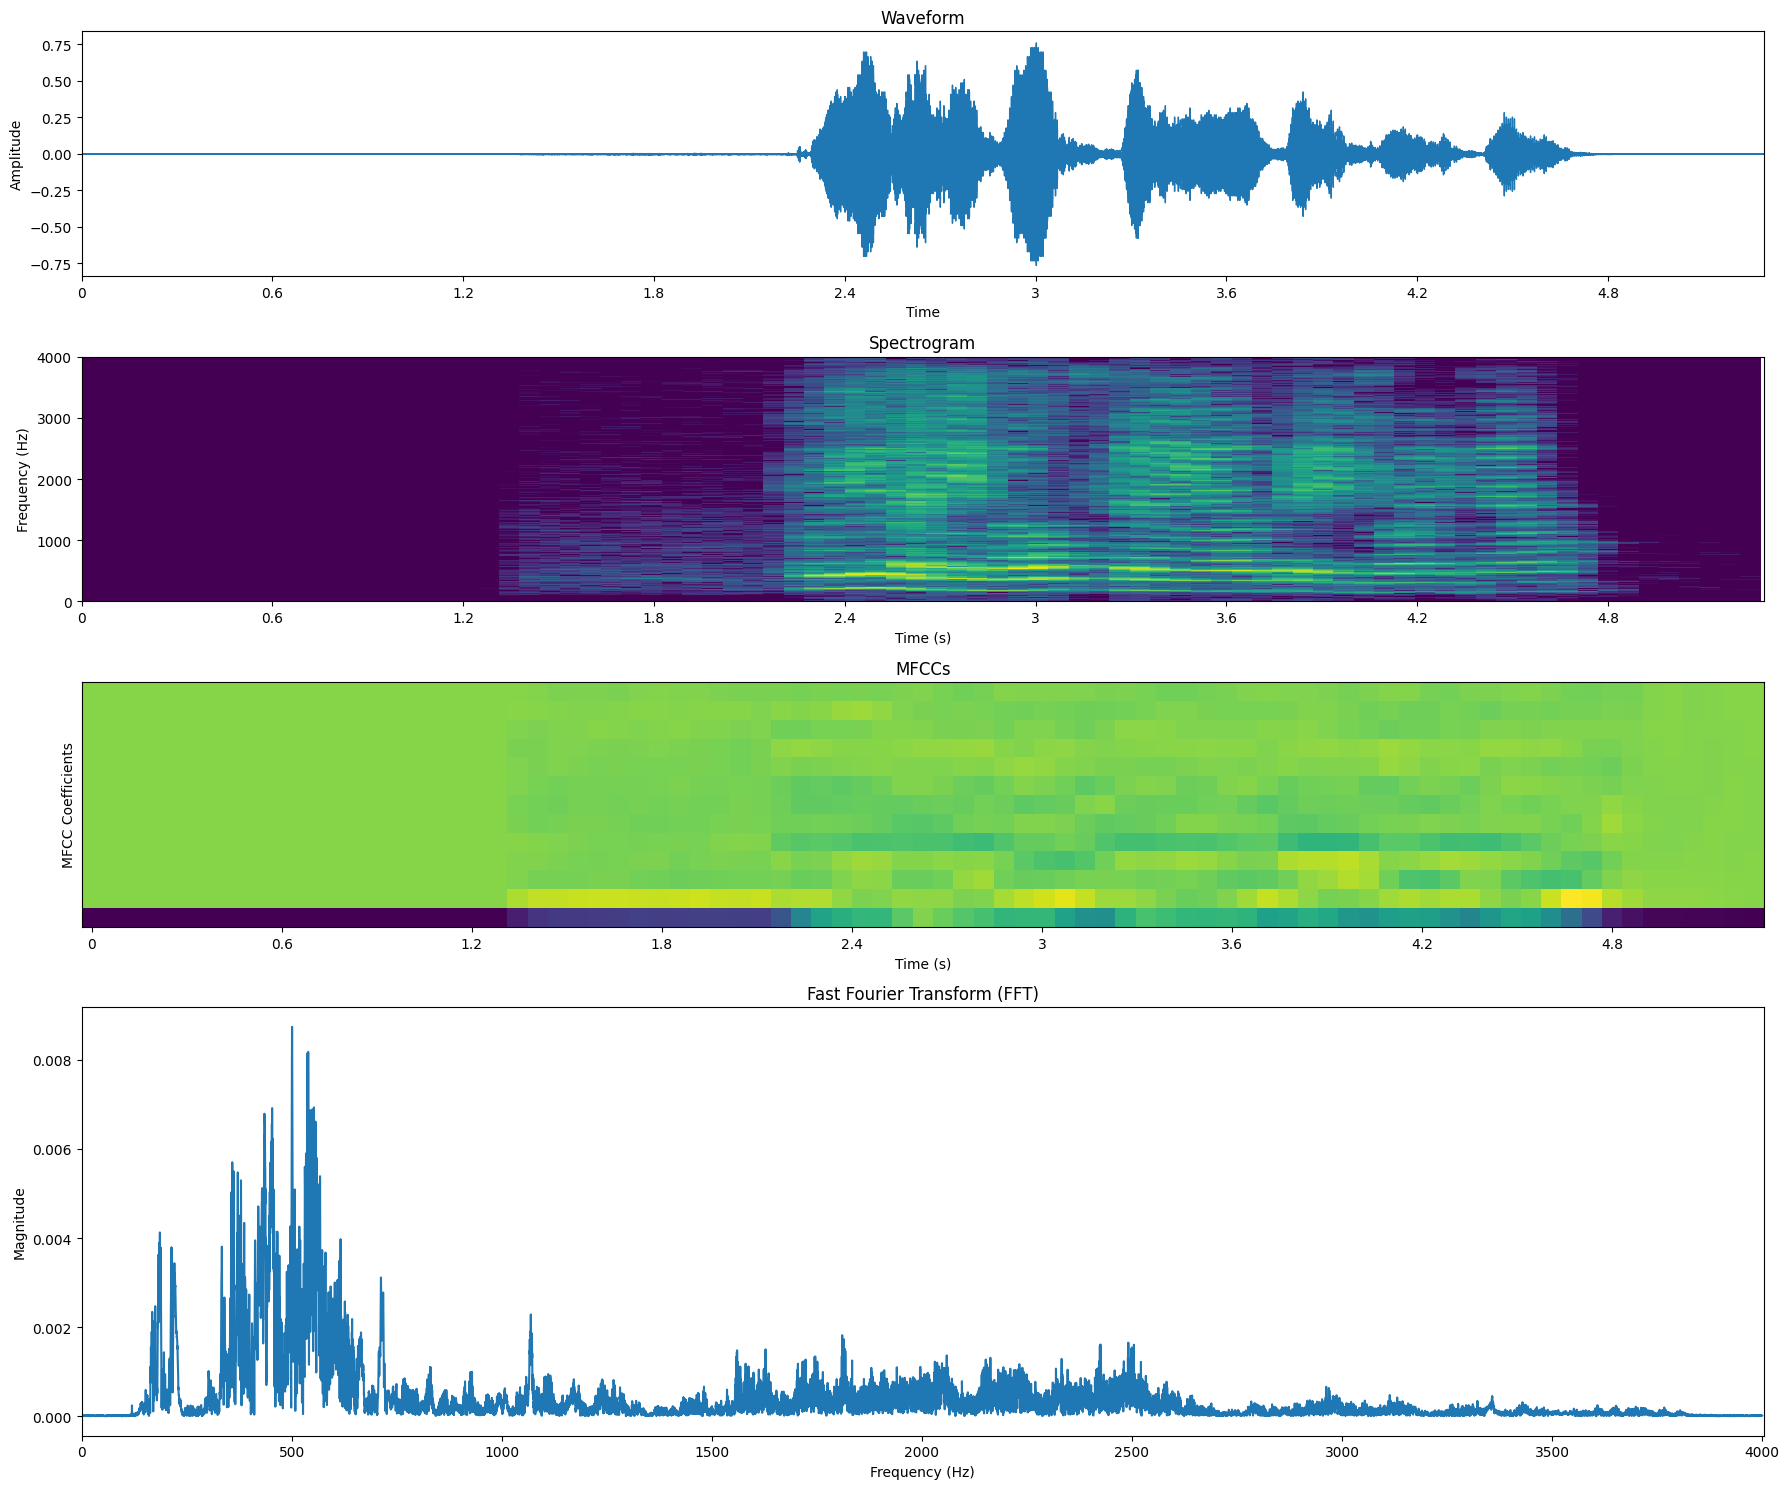

<Figure size 640x480 with 0 Axes>

text script audio: I need help setting up a joint account
intent class: joint_account


In [7]:
### Sample Data 1

sample_data = minds_en["train"][10]
eda_plots(sample_data)
ipd.Audio(sample_data["audio"]['path'])

### Sample Data 2

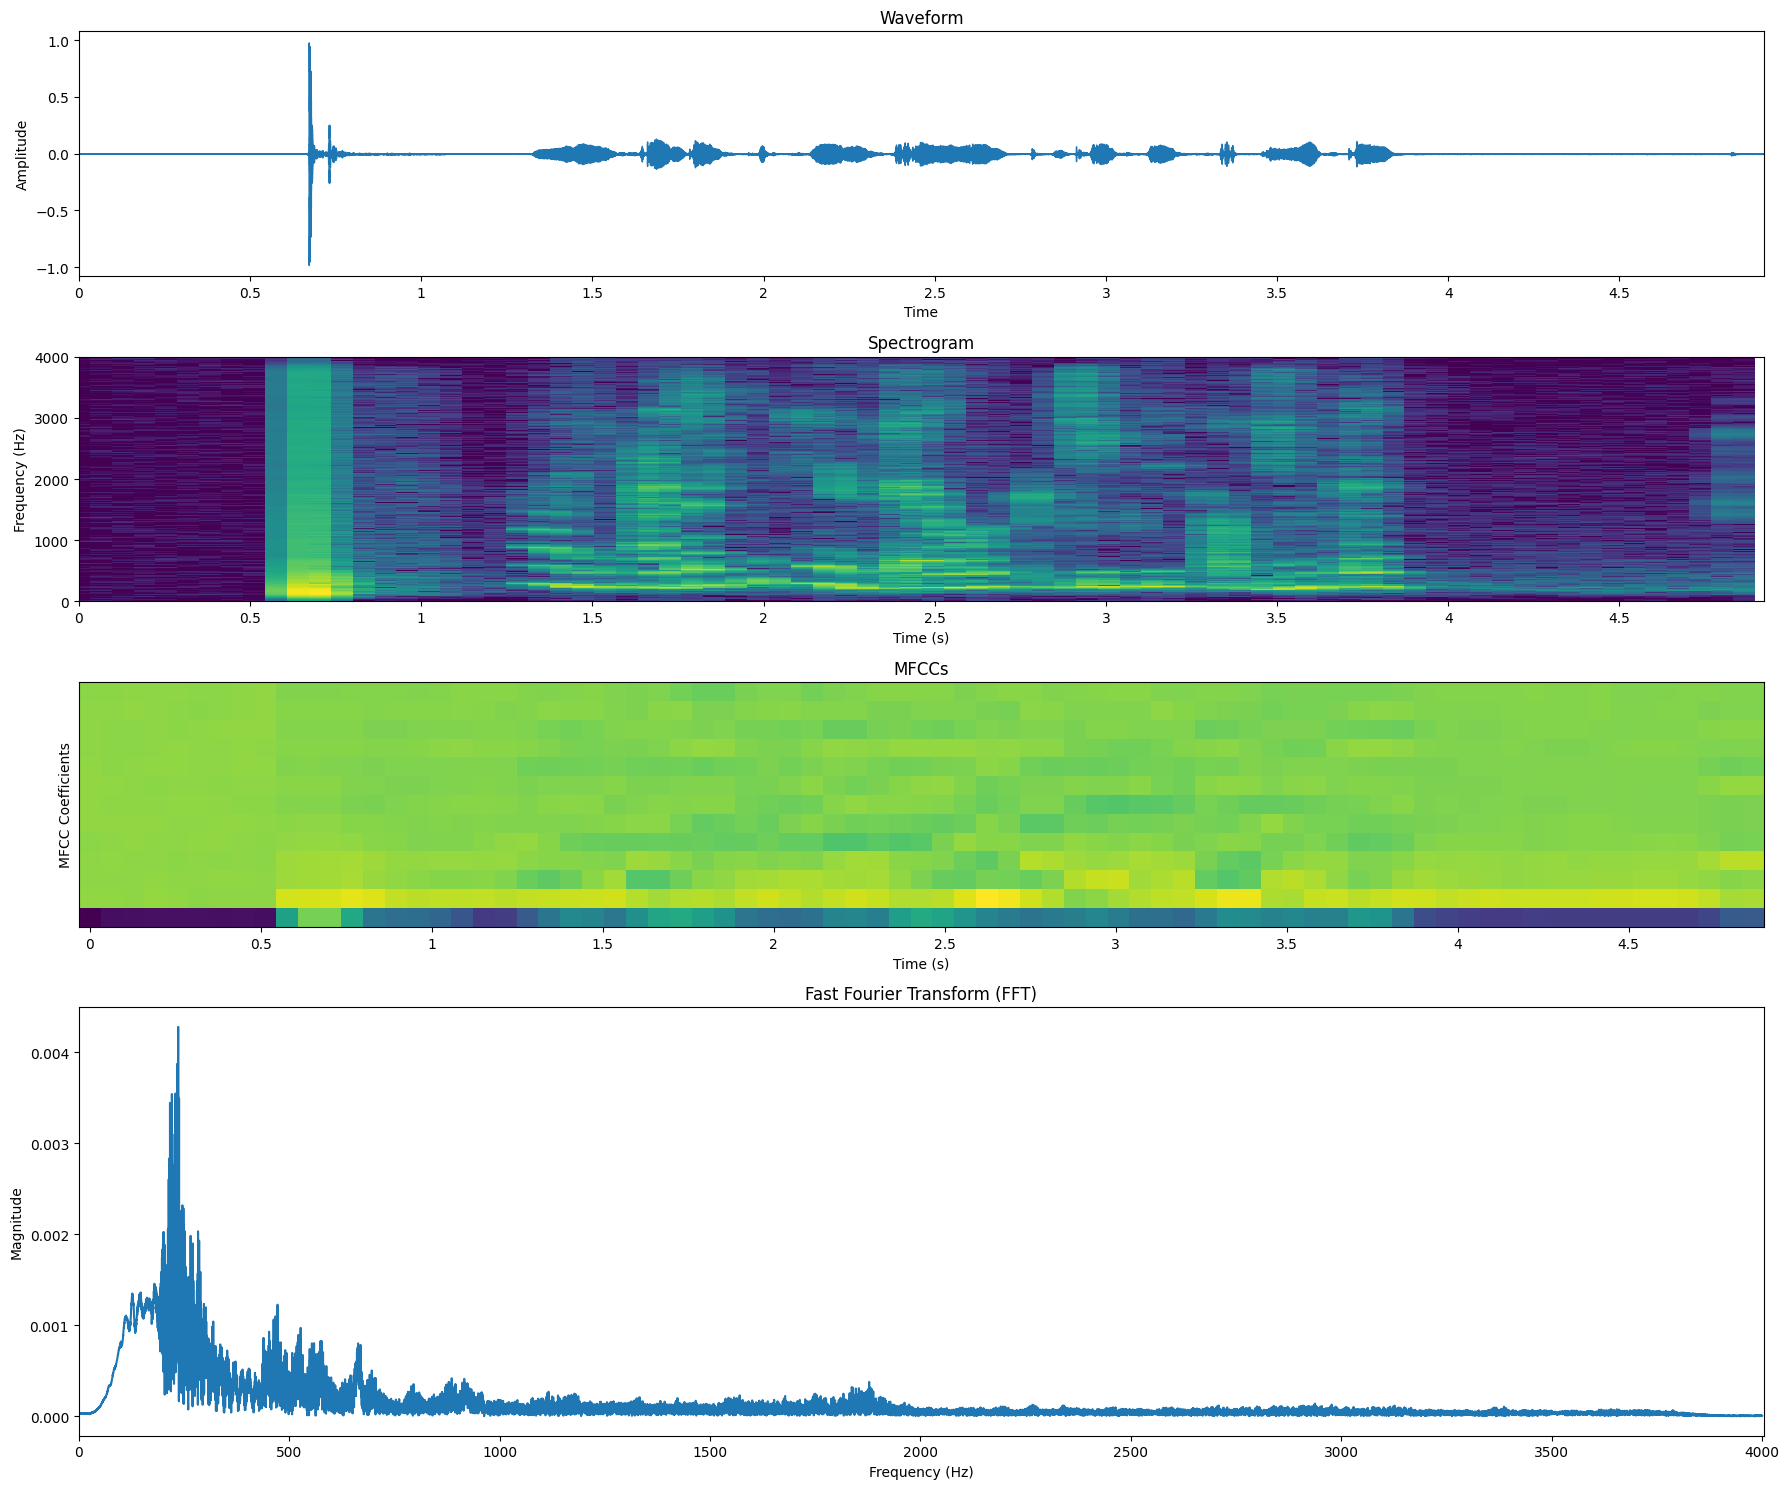

<Figure size 640x480 with 0 Axes>

text script audio: hi I'd like to pay the bills could you please help me with this
intent class: pay_bill


In [8]:
### Sample Data 2

sample_data = minds_en["train"][99]
eda_plots(sample_data)
ipd.Audio(sample_data["audio"]['path'])

### Sample Data 3

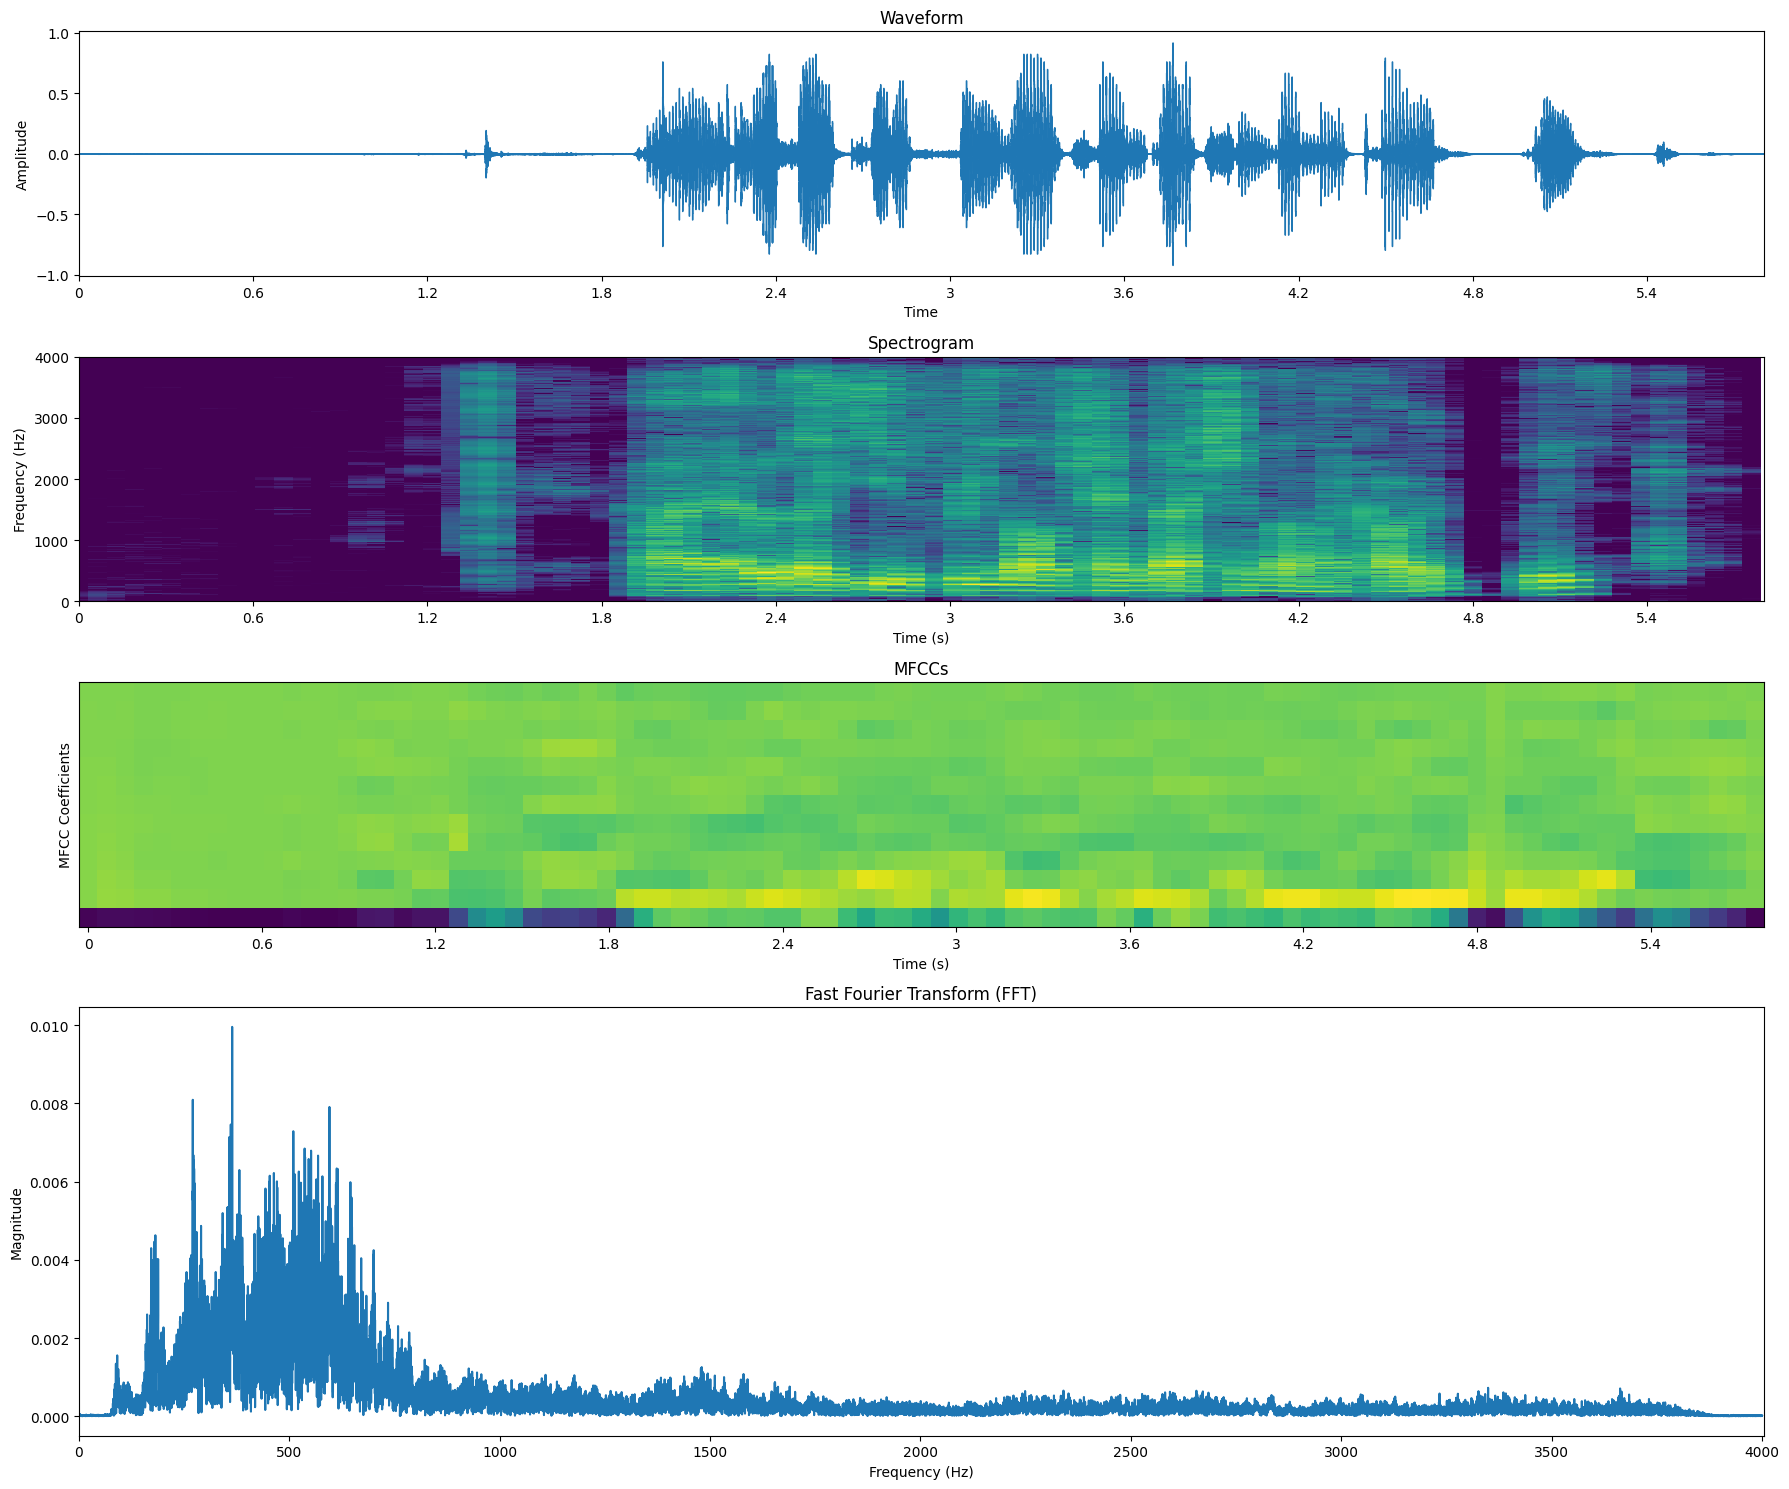

<Figure size 640x480 with 0 Axes>

text script audio: I would like you to freeze all transactions on my card please
intent class: freeze


In [9]:
### Sample Data 3

sample_data = minds_en["train"][150]
eda_plots(sample_data)
ipd.Audio(sample_data["audio"]['path'])

### Additional Insights

In [10]:
# convert to format pandas DataFrame
minds_en.set_format(type="pandas")
df = minds_en["train"][:]

intent_names = minds_en["train"].features["intent_class"].names

def mapping_intent(i):
    return intent_names[i]

df["intent_name"] = df["intent_class"].map(mapping_intent)
df["len_transcription"] = df["transcription"].map(len)

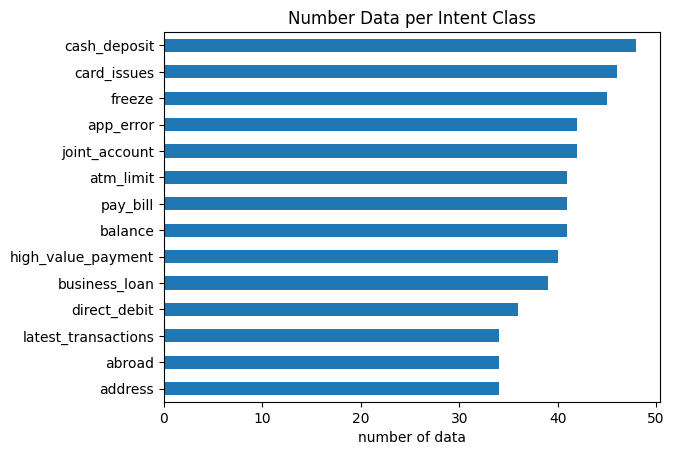

In [11]:
# number data each intent class
df.intent_name.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.title("Number Data per Intent Class")
plt.xlabel("number of data")
plt.ylabel("")
plt.show()

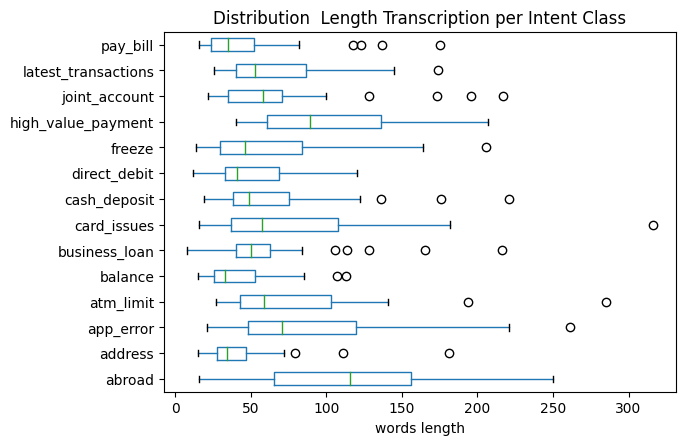

In [12]:
# distribution len of transcription text per intent class
df.boxplot("len_transcription", by="intent_name", vert=False)
plt.title("Distribution  Length Transcription per Intent Class")
plt.xlabel("words length")
plt.ylabel("")
plt.suptitle("")
plt.grid(False)
# plt.tight_layout()
plt.show()

In [13]:
# reset to datasets format

minds_en.reset_format()

# Pre-processing

In [14]:
minds_14 = load_dataset("PolyAI/minds14", name="en-US", split="train[:300]")
# to download all data for multi-lingual fine-tuning uncomment following line
# minds_14 = load_dataset("PolyAI/minds14", "all")

minds = minds_14.train_test_split(test_size=0.2)
minds = minds.remove_columns(["english_transcription", "intent_class", "lang_id"])

In [15]:
# ## ====================================================================================
# # ## IF using jupyter notebook use this code
# ## ====================================================================================

# autoprocessor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")
# minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
# minds["train"][0]

# def uppercase(example):
#     return {"transcription": example["transcription"].upper()}

# minds = minds.map(uppercase)

# def prepare_dataset(batch, processor = autoprocessor):
#     audio = batch["audio"]
#     batch = processor(audio["array"], sampling_rate=audio["sampling_rate"], text=batch["transcription"])
#     batch["input_length"] = len(batch["input_values"][0])
#     return batch

# encoded_minds = minds.map(prepare_dataset, remove_columns=minds.column_names["train"], num_proc=4)


# ====================================================================================
## IF using google colab you can uncomment and use this part
# ====================================================================================

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds["train"][0]

def uppercase(example):
    return {"transcription": example["transcription"].upper()}

minds = minds.map(uppercase)

def prepare_dataset(batch):
    audio = batch["audio"]
    batch = processor(audio["array"], sampling_rate=audio["sampling_rate"], text=batch["transcription"])
    batch["input_length"] = len(batch["input_values"][0])
    return batch

encoded_minds = minds.map(prepare_dataset, remove_columns=minds.column_names["train"], num_proc=4)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/240 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/60 [00:00<?, ? examples/s]

# Training

In [64]:
import evaluate

wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [17]:
# # ====================================================================================
# # ## IF using jupyter notebook use this code
# # ====================================================================================

# def compute_metrics(pred, processor=autoprocessor):
#     pred_logits = pred.predictions
#     pred_ids = np.argmax(pred_logits, axis=-1)

#     pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

#     pred_str = processor.batch_decode(pred_ids)
#     label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

#     wer = wer_metric.compute(predictions=pred_str, references=label_str)

#     return {"wer": wer}


# ====================================================================================
## IF using google colab you can uncomment and use this part
# ====================================================================================

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [18]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union


@dataclass
class DataCollatorCTCWithPadding:
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"][0]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(input_features, padding=self.padding, return_tensors="pt")

        labels_batch = self.processor.pad(labels=label_features, padding=self.padding, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [19]:
# # ====================================================================================
# # ## IF using jupyter notebook use this code
# # ====================================================================================

# data_collator = DataCollatorCTCWithPadding(processor=autoprocessor, padding="longest") # IF jupyter



# ====================================================================================
## IF using google colab you can uncomment and use this part
# ====================================================================================

data_collator = DataCollatorCTCWithPadding(processor=processor, padding="longest")

In [20]:
# ## ====================================================================================
# # ## IF using jupyter notebook use this code
# # # ====================================================================================

# from transformers import AutoModelForCTC, TrainingArguments, Trainer

# model = AutoModelForCTC.from_pretrained(
#     "facebook/wav2vec2-base",
#     ctc_loss_reduction="mean",
#     pad_token_id=autoprocessor.tokenizer.pad_token_id,
# )


# ====================================================================================
# IF using google colab you can uncomment and use this part
# ====================================================================================


from transformers import AutoModelForCTC, TrainingArguments, Trainer

model = AutoModelForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
training_args = TrainingArguments(
    output_dir="asr_mind_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    warmup_steps=500,
    max_steps=3000,
    gradient_checkpointing=True,
    fp16=True,                               # True only use GPU/ CUDA
    group_by_length=True,
    evaluation_strategy="steps",
    save_steps=500,
    eval_steps=500,
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["test"],
    # tokenizer=autoprocessor,                              # IF using jupyter notebook
    tokenizer=processor,                              # IF using google colab
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
500,7.635000,3.195347,1.000000
1000,2.523700,1.572335,0.764946
1500,0.429300,2.208133,0.546196
2000,0.135100,2.497283,0.498641
2500,0.066700,2.917804,0.486413
3000,0.039800,3.090311,0.487772


TrainOutput(global_step=3000, training_loss=1.804929828643799, metrics={'train_runtime': 5794.599, 'train_samples_per_second': 4.142, 'train_steps_per_second': 0.518, 'total_flos': 3.071427084210839e+18, 'train_loss': 1.804929828643799, 'epoch': 100.0})

In [22]:
trainer.save_model('asr_mind_wav2vec2_300_max_steps_3000')

In [23]:
# ###Download the saved model
# # zip file model
# !zip -r /content/asr_mind_wav2vec2_300_max_steps_3000.zip /content/asr_mind_wav2vec2_300_max_steps_3000/

  adding: content/asr_mind_wav2vec2_300_max_steps_3000/ (stored 0%)
  adding: content/asr_mind_wav2vec2_300_max_steps_3000/special_tokens_map.json (deflated 45%)
  adding: content/asr_mind_wav2vec2_300_max_steps_3000/tokenizer_config.json (deflated 47%)
  adding: content/asr_mind_wav2vec2_300_max_steps_3000/preprocessor_config.json (deflated 38%)
  adding: content/asr_mind_wav2vec2_300_max_steps_3000/config.json (deflated 67%)
  adding: content/asr_mind_wav2vec2_300_max_steps_3000/training_args.bin (deflated 49%)
  adding: content/asr_mind_wav2vec2_300_max_steps_3000/vocab.json (deflated 55%)
  adding: content/asr_mind_wav2vec2_300_max_steps_3000/pytorch_model.bin (deflated 7%)


In [24]:
# from google.colab import files
# # files.download("/content/asr_mind_wav2vec2_300_max_steps_3000.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Inference

In [28]:
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd

from glob import glob
import seaborn as sns
import pandas as pd

import librosa
import librosa.display

import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from transformers import AutoProcessor
from scipy.fft import fft, fftfreq

from transformers import AutoModelForCTC
from transformers import pipeline

In [29]:
# use unseen data

dataset = load_dataset("PolyAI/minds14", "en-US", split="train[299:350]")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset = dataset.map(uppercase)

In [30]:
# ### cek length char each 

# lens = []
# ids = []
# for i in range(len(dataset)):
#   ids.append(i)
#   lens.append(len(dataset[i]["transcription"]))

# pd.DataFrame({
#      'idx':  ids,
#      'len': lens
# })

### Sample 0

In [66]:
sampling_rate = dataset.features["audio"].sampling_rate
audio_sample = dataset[0]
audio_text = audio_sample["transcription"]
audio_file = audio_sample["audio"]["path"]
print(f"transcription: {audio_text}")
print(f'intent class: {dataset.features["intent_class"].names[audio_sample["intent_class"]]}')

ipd.Audio(audio_file)

transcription: HI I'M GOING TO BE GOING ABROAD AND I'D LIKE TO KNOW IF I CAN USE MY CARD IN ENGLAND WHILE I'M THERE AND WORK IF I HAVE TO DO ANYTHING SPECIAL TO ACTIVATE IT
intent class: abroad


In [70]:
# transcriber = pipeline("automatic-speech-recognition", model="/content/asr_mind_wav2vec2_300_max_steps_3000/") # need directory to config.json file
transcriber = pipeline("automatic-speech-recognition", model="./saved_models/asr_mind_wav2vec2_300_max_steps_3000") # need directory to config.json file
reference = audio_text
predicted =  transcriber(audio_file)['text']

print(f"transcription referece:\n{reference}")
print(f"transcription prediction:\n{predicted}")

transcription referece:
HI I'M GOING TO BE GOING ABROAD AND I'D LIKE TO KNOW IF I CAN USE MY CARD IN ENGLAND WHILE I'M THERE AND WORK IF I HAVE TO DO ANYTHING SPECIAL TO ACTIVATE IT
transcription prediction:
HI I'M GOING TO BE GOING ABROAD AND I'D LIKE TO KNOW IF I CAN USE MY CARD IN ENGLAND WHILE I'M THERE AND WORK IF I HAVE TO DO ANYTHING SPECIAL TO ACTIVATE IT


In [69]:
# CER & WER score
wer_score = wer_metric.compute(predictions = [predicted], references = [reference])
cer_score = cer_metric.compute(predictions = [predicted], references = [reference])
print(f"WER:{round(wer_score, 2)}")
print(f"CER:{round(cer_score, 2)}")

WER:0.0
CER:0.0


### Sample 1

In [71]:
sampling_rate = dataset.features["audio"].sampling_rate
audio_sample = dataset[3]
audio_text = audio_sample["transcription"]
audio_file = audio_sample["audio"]["path"]
print(f"transcription: {audio_text}")
print(f'intent class: {dataset.features["intent_class"].names[audio_sample["intent_class"]]}')

ipd.Audio(audio_file)

transcription: HI I'M GOING TO BE TRAVELING ABROAD IN JAPAN AND I JUST WONDERED IF I'M GOING TO BE ABLE TO USE MY BANK CARD WHEN I'M THERE IF YOU COULD LET ME KNOW THAT WOULD BE GREAT THANK YOU
intent class: abroad


In [72]:
# transcriber = pipeline("automatic-speech-recognition", model="/content/asr_mind_wav2vec2_300_max_steps_3000/") # need directory to config.json file
transcriber = pipeline("automatic-speech-recognition", model="./saved_models/asr_mind_wav2vec2_300_max_steps_3000") # need directory to config.json file
reference = audio_text
predicted =  transcriber(audio_file)['text']

print(f"transcription referece:\n{reference}")
print(f"transcription prediction:\n{predicted}")

transcription referece:
HI I'M GOING TO BE TRAVELING ABROAD IN JAPAN AND I JUST WONDERED IF I'M GOING TO BE ABLE TO USE MY BANK CARD WHEN I'M THERE IF YOU COULD LET ME KNOW THAT WOULD BE GREAT THANK YOU
transcription prediction:
HI 'M GOING TO BE TRAVELING ABROAD I'M GOING PAY AM AND I JUST WONDERD IF I'M GOINGE TO BE ABLE TO USE MY BANK CARD WHE I'M THERE IF YOU COULD LET ME KNOW THAT WOULD BE GREIHT THANK YOU


In [73]:
# CER & WER score
wer_score = wer_metric.compute(predictions = [predicted], references = [reference])
cer_score = cer_metric.compute(predictions = [predicted], references = [reference])
print(f"WER:{round(wer_score, 2)}")
print(f"CER:{round(cer_score, 2)}")

WER:0.23
CER:0.1


### Sample 2

In [74]:
sampling_rate = dataset.features["audio"].sampling_rate
audio_sample = dataset[4]
audio_text = audio_sample["transcription"]
audio_file = audio_sample["audio"]["path"]
print(f"transcription: {audio_text}")
print(f'intent class: {dataset.features["intent_class"].names[audio_sample["intent_class"]]}')

ipd.Audio(audio_file)

transcription: DO I NEED TO DO ANYTHING FOR MY CARD TO WORK WHEN I'M ABROAD
intent class: abroad


In [75]:
# transcriber = pipeline("automatic-speech-recognition", model="/content/asr_mind_wav2vec2_300_max_steps_3000/") # need directory to config.json file
transcriber = pipeline("automatic-speech-recognition", model="./saved_models/asr_mind_wav2vec2_300_max_steps_3000") # need directory to config.json file
reference = audio_text
predicted =  transcriber(audio_file)['text']

print(f"transcription referece:\n{reference}")
print(f"transcription prediction:\n{predicted}")

transcription referece:
DO I NEED TO DO ANYTHING FOR MY CARD TO WORK WHEN I'M ABROAD
transcription prediction:
DO I NEED T DO ANY THNG FROM MY CARD TDO WORK WHEN I'M ABROAD


In [76]:
# CER & WER score
wer_score = wer_metric.compute(predictions = [predicted], references = [reference])
cer_score = cer_metric.compute(predictions = [predicted], references = [reference])
print(f"WER:{round(wer_score, 2)}")
print(f"CER:{round(cer_score, 2)}")

WER:0.36
CER:0.1


### Sample 3

In [77]:
sampling_rate = dataset.features["audio"].sampling_rate
audio_sample = dataset[23]
audio_text = audio_sample["transcription"]
audio_file = audio_sample["audio"]["path"]
print(f"transcription: {audio_text}")
print(f'intent class: {dataset.features["intent_class"].names[audio_sample["intent_class"]]}')

ipd.Audio(audio_file)

transcription: COULD YOU TELL ME ABOUT DIRECT DEBIT PLEASE
intent class: direct_debit


In [79]:
# transcriber = pipeline("automatic-speech-recognition", model="/content/asr_mind_wav2vec2_300_max_steps_3000/") # need directory to config.json file
transcriber = pipeline("automatic-speech-recognition", model="./saved_models/asr_mind_wav2vec2_300_max_steps_3000") # need directory to config.json file
reference = audio_text
predicted =  transcriber(audio_file)['text']

print(f"transcription referece:\n{reference}")
print(f"transcription prediction:\n{predicted}")

transcription referece:
COULD YOU TELL ME ABOUT DIRECT DEBIT PLEASE
transcription prediction:
HI COULD YOU TELL ME ABOUT DORRETGAPBIC' PLEASEBANK


In [81]:
# CER & WER score
wer_score = wer_metric.compute(predictions = [predicted], references = [reference])
cer_score = cer_metric.compute(predictions = [predicted], references = [reference])
print(f"WER:{round(wer_score, 2)}")
print(f"CER:{round(cer_score, 2)}")

WER:0.5
CER:0.35


### Sample 4

In [82]:
sampling_rate = dataset.features["audio"].sampling_rate
audio_sample = dataset[32]
audio_text = audio_sample["transcription"]
audio_file = audio_sample["audio"]["path"]
print(f"transcription: {audio_text}")
print(f'intent class: {dataset.features["intent_class"].names[audio_sample["intent_class"]]}')

ipd.Audio(audio_file)

transcription: HOW DO I SET UP A DIRECT DEBIT
intent class: direct_debit


In [84]:
# transcriber = pipeline("automatic-speech-recognition", model="/content/asr_mind_wav2vec2_300_max_steps_3000/") # need directory to config.json file
transcriber = pipeline("automatic-speech-recognition", model="./saved_models/asr_mind_wav2vec2_300_max_steps_3000") # need directory to config.json file
reference = audio_text
predicted =  transcriber(audio_file)['text']

print(f"transcription referece:\n{reference}")
print(f"transcription prediction:\n{predicted}")

transcription referece:
HOW DO I SET UP A DIRECT DEBIT
transcription prediction:
HOW DO I SET UP A DRECT ADBIT


In [85]:
# CER & WER score
wer_score = wer_metric.compute(predictions = [predicted], references = [reference])
cer_score = cer_metric.compute(predictions = [predicted], references = [reference])
print(f"WER:{round(wer_score, 2)}")
print(f"CER:{round(cer_score, 2)}")

WER:0.25
CER:0.1


# Recommendations
- Some transcriptions from the dataset are not accurate, need to review in depth
- Remove the background noises
- Fine-tune the model on larger data

# Appendix


## Metric evaluation
#### WER (Word Error Rate)

`WER = (S+I+D)/N`


Detail:
- S = Subsitution
- I = Insertion
- D = Deletion
- N = Number of words in the reference transcript


**WER drawbacks**
1. There is no differentiation between the words that are essential to the meaning of the sentence and those that are not as important.
2. It doesn’t take into consideration if two words differ just by one character or if they differ completely (alternatively use CER)

**What causes speech-to-text transcription errors?**
1. Accents and variations in rate of speech
2. Homophones, homographs and homonyms
3. Crosstalk aka overlapping dialogue
4. Audio quality and background noise
5. Acronyms and industry-specific jargon


**How to improve ASR?**
1. Use high-quality headset microphone that holds the microphone in a consistent position directly in front of your mouth
2. Eliminate echoes and noises

# References
- MInDS-14 Dataset:
    - Paper: [Multilingual and Cross-Lingual Detection from Spoken Data](https://arxiv.org/abs/2104.08524)
    - https://huggingface.co/datasets/PolyAI/minds14
- wav2vec2 model:
    - Paper: [wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations](https://arxiv.org/abs/2006.11477)
- Automatic Speech Recognition - Hugging Face:
    - https://huggingface.co/tasks/automatic-speech-recognition
- WER metric:
    - https://medium.com/@bethworthy/what-is-word-error-rate-measuring-the-wer-of-machine-generated-transcripts-and-its-limitations-1457be914f3b
    - https://medium.com/nlplanet/two-minutes-nlp-intro-to-word-error-rate-wer-for-speech-to-text-fc17a98003ea#:~:text=Basically%2C%20WER%20is%20the%20number,words%20in%20the%20reference%20transcript.&text=Lower%20WER%20often%20indicates%20that,often%20indicates%20lower%20ASR%20accuracy.
    - https://www.clari.com/blog/word-error-rate/#:~:text=What%20is%20Word%20Error%20Rate,the%20transcript%20is%2080%25%20accurate.
    - https://www.journalofaccountancy.com/issues/2019/jan/voice-recognition-accuracy.html#:~:text=Eliminate%20echoes%20and%20noises.,computer's%20ability%20to%20understand%20you.
- Error ffmpeg file not found during inference (for Windows users):
    - https://discuss.huggingface.co/t/audio-classification-pipeline-valueerror-ffmpeg-was-not-found-but-is-required-to-load-audio-files-from-filename/16137 
    - https://ffmpeg.org/download.html
    - https://www.youtube.com/watch?v=jZLqNocSQDM
    - type command `choco install ffmpeg` in powershell (run as Administrator)